In [1]:
suppressMessages(library(ArchR))
ss <- function(x, pattern, slot = 1, ...) { sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)
suppressMessages(library(Seurat))
suppressMessages(library(SingleCellExperiment))
library(tidyverse)

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()         masks data.table::between()
✖ dplyr::collapse()        masks IRanges::collapse()
✖ dplyr::combine()         masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()           masks matrixStats::count()
✖ dplyr::desc()            masks IRanges::desc()
✖ tidyr::expand()          masks Matrix::expand(), S4Vectors::expand()
✖ tidyr::extract()         masks magrittr::extract()
✖ dplyr::filter()          masks stats::filter()
✖ dplyr::first()           masks data.table::first(), S4Vectors::first()
✖ dplyr::lag()             masks stats::lag()
✖ dplyr::last()            ma

In [2]:
##################################
### set Arrow File parameters ####
addArchRThreads(threads = 24)

##################################
### load rheMac10 ArchR genome ###
GENOMEDIR='/home/bnphan/resources/genomes/rheMac10'
load(file.path(GENOMEDIR,'rheMac10_liftoff_GRCh38.p13_ArchR_annotations.rda'))

Setting default number of Parallel threads to 24.



In [3]:
PROJDIR='../../../data/tidy_data/ArchRProjects'
proj = loadArchRProject(file.path(PROJDIR,'ArchR_DLPFC_scATAC'), showLogo = FALSE)
projNeuron = loadArchRProject(file.path(PROJDIR,'ArchR_snATAC_DLPFC_neuron'), showLogo = FALSE)
projGlia = loadArchRProject(file.path(PROJDIR,'ArchR_snATAC_DLPFC_glia'), showLogo = FALSE)

Successfully loaded ArchRProject!

Successfully loaded ArchRProject!

Successfully loaded ArchRProject!



# Add predictedRNA2ATAC co-clustering labels from sub-analyses

In [4]:
df_Neuron = getCellColData(projNeuron)
df_Glia = getCellColData(projGlia)

columns = names(getCellColData(projGlia))
df_label = rbind(df_Neuron[,columns],df_Glia[,columns] )
head(df_label)

DataFrame with 6 rows and 34 columns
                                        Sample TSSEnrichment ReadsInTSS
                                   <character>     <numeric>  <numeric>
London_DLPFC-2#GGATGTAAGTAAGTCC London_DLPFC-2         6.535       1782
London_DLPFC-2#GAACCAAAGAGAAGGG London_DLPFC-2         5.416       1671
London_DLPFC-2#GGCAGGATCATAACCA London_DLPFC-2         7.533       2077
London_DLPFC-2#TTTGCGGAGTTCCCAC London_DLPFC-2         7.440       2431
London_DLPFC-2#TCCAGCAAGGTCAAAG London_DLPFC-2         8.393       2348
London_DLPFC-2#ACTTGCACAAGCTAAA London_DLPFC-2         7.577       2185
                                ReadsInPromoter PromoterRatio    PassQC
                                      <numeric>     <numeric> <numeric>
London_DLPFC-2#GGATGTAAGTAAGTCC           12202     0.0813814         1
London_DLPFC-2#GAACCAAAGAGAAGGG           12317     0.0876780         1
London_DLPFC-2#GGCAGGATCATAACCA           13971     0.0999156         1
London_DLPFC-2#TTTGCGGAGTTC

In [5]:
## transfer labels via cell barcodes
df_label = df_label %>% as.data.frame() %>%
    mutate(predictedGroup_RNA2ATACCo = ifelse(grepl('EXC|INH', Celltype1), predictedGroup_RNA2ATACCo, Celltype1))
df_label = df_label[getCellNames(proj),]
proj <- addCellColData(ArchRProj = proj, data = df_label$predictedGroup_RNA2ATACCo,
    cells = rownames(df_label), name = "predictedGroup_RNA2ATACCo", force = TRUE)
proj <- addCellColData(ArchRProj = proj, data = df_label$predictedGroup_RNA2ATACCo,
    cells = rownames(df_label), name = "Celltype2", force = TRUE)

Overriding previous entry for predictedGroup_RNA2ATACCo

Overriding previous entry for Celltype2



In [6]:
table(proj$Celltype2)


        Astro          Endo L2.CUX2.MEIS2  L3.CUX2.RORB    L4.5.TBX15 
         7326           270          8047          1620          1967 
      L4.ALPL        L4.TYR    L5.6.NR4A2       L5.PCP4     L5.POU3F1 
         2907          1039           316           486           170 
     L6.ITGA8       L6.NKD1       L6.SYT6         LAMP5     Microglia 
         1137           445           541           635          3601 
        Mural          NDNF         Oligo           OPC         PV.BC 
         1010           792          3024          2434          1678 
       PV.ChC           SST           VIP 
          394          2366          1443 

In [7]:
## subset to cells with integrated labels
idxPass <- which(!is.na(proj$predictedGroup_RNA2ATACCo) & 
                 proj$predictedGroup_RNA2ATACCo %ni% c('Drop', 'NA.', 'TH')) # too few cluster

cellsPass <- proj$cellNames[idxPass]
proj = proj[cellsPass, ]

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-6efdf12bfb730-Date-2022-01-07_Time-20-18-17.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-6efdf12bfb730-Date-2022-01-07_Time-20-18-17.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-6efdf2161a75d-Date-2022-01-07_Time-20-18-18.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-6efdf2161a75d-Date-2022-01-07_Time-20-18-18.log



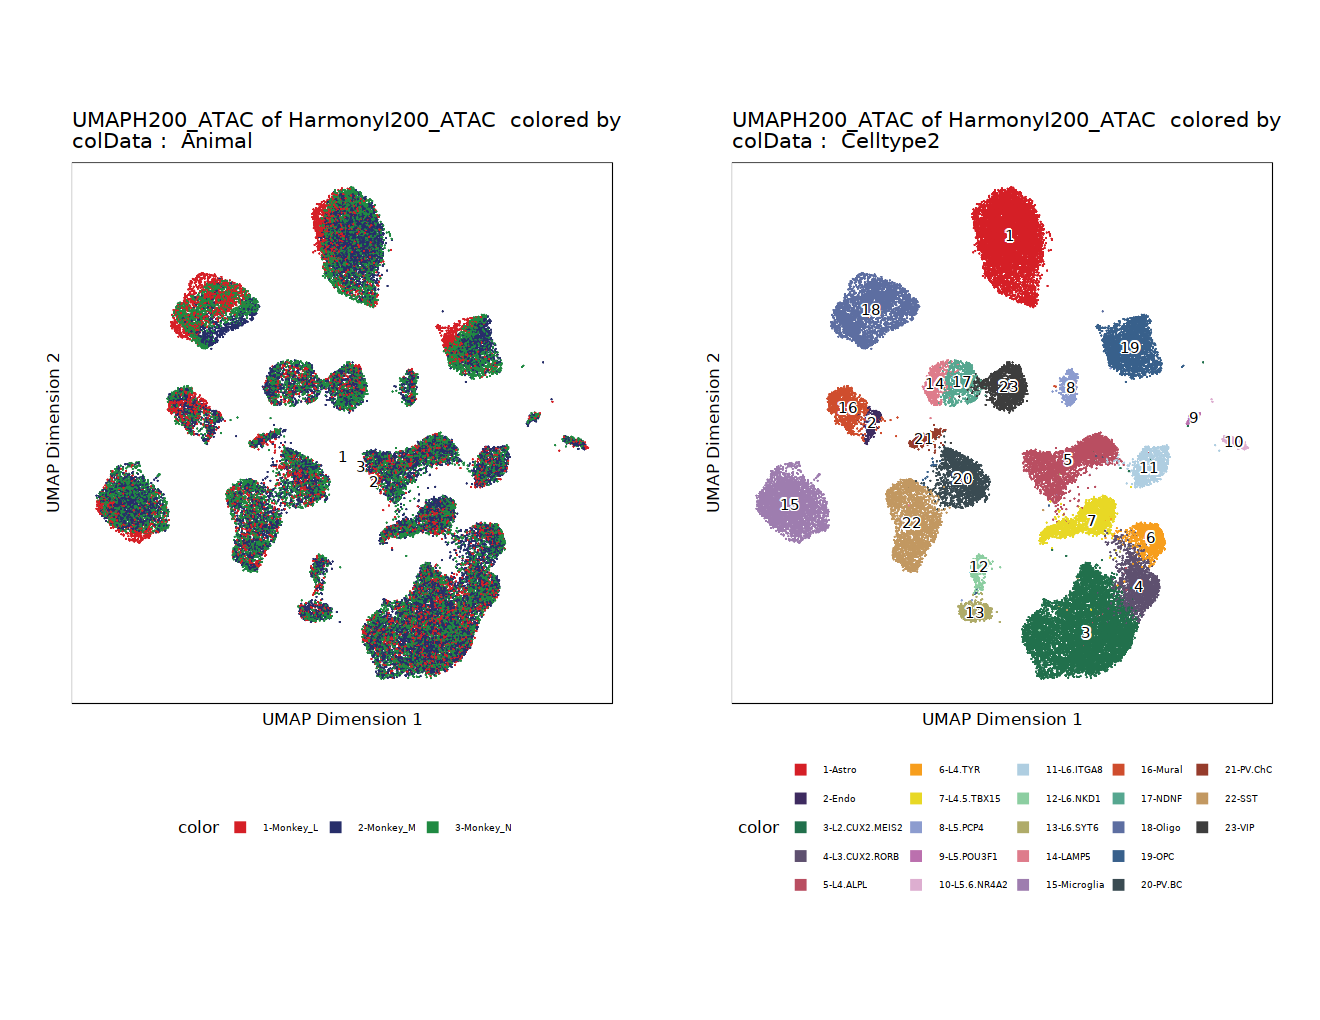

In [8]:
## make UMAP plots
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "Animal", embedding = "UMAPH200_ATAC")

p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", 
                    name = "Celltype2", embedding = "UMAPH200_ATAC")


ggAlignPlots(p1, p2,  type = "h")

In [9]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

# Call peaks using integrated clusters

In [10]:
# make group coverage, call peaks, and 
proj<-addGroupCoverages(proj, groupBy="Celltype2", 
                        minReplicates = 3, maxReplicates = 5, force = TRUE,
                        minCells = 40, maxCells = 1000)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-6efdf492f0fbb-Date-2022-01-07_Time-20-18-34.log
If there is an issue, please report to github with logFile!

Astro (1 of 23) : CellGroups N = 5

Endo (2 of 23) : CellGroups N = 4

L2.CUX2.MEIS2 (3 of 23) : CellGroups N = 5

L3.CUX2.RORB (4 of 23) : CellGroups N = 5

L4.ALPL (5 of 23) : CellGroups N = 5

L4.TYR (6 of 23) : CellGroups N = 5

L4.5.TBX15 (7 of 23) : CellGroups N = 5

L5.PCP4 (8 of 23) : CellGroups N = 5

L5.POU3F1 (9 of 23) : CellGroups N = 3

L5.6.NR4A2 (10 of 23) : CellGroups N = 5

L6.ITGA8 (11 of 23) : CellGroups N = 5

L6.NKD1 (12 of 23) : CellGroups N = 5

L6.SYT6 (13 of 23) : CellGroups N = 5

LAMP5 (14 of 23) : CellGroups N = 5

Microglia (15 of 23) : CellGroups N = 5

Mural (16 of 23) : CellGroups N = 5

NDNF (17 of 23) : CellGroups N = 5

Oligo (18 of 23) : CellGroups N = 5

OPC (19 of 23) : CellGroups N = 5

PV.BC (20 of 23) : CellGroups N = 5

PV.ChC (21 of 23) : CellGroups N = 5

SST (22 of 23) : CellGroups 

In [12]:
# call peaks 
proj<-addReproduciblePeakSet(proj, groupBy = "Celltype2", 
                             plot = FALSE, genomeSize = 2.7e9)

Searching For MACS2..

Found with $path!

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-6efdf4ca140f3-Date-2022-01-07_Time-22-51-49.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-01-07 22:51:49 : Peak Calling Parameters!, 0.006 mins elapsed.



                      Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
Astro                 Astro   7326       5000           5 1000 1000   150000
Endo                   Endo    270        232           4   44   75   116000
L2.CUX2.MEIS2 L2.CUX2.MEIS2   8047       5000           5 1000 1000   150000
L3.CUX2.RORB   L3.CUX2.RORB   1620       1620           5  283  365   150000
L4.ALPL             L4.ALPL   2907       2907           5  415  709   150000
L4.TYR               L4.TYR   1039       1039           5  171  243   150000
L4.5.TBX15       L4.5.TBX15   1967       1967           5  333  440   150000
L5.PCP4             L5.PCP4    486        486           5   64  123   150000
L5.POU3F1         L5.POU3F1    170        170           3   56   57    85000
L5.6.NR4A2       L5.6.NR4A2    316        316           5   50   84   150000
L6.ITGA8           L6.ITGA8   1137       1137           5  167  263   150000
L6.NKD1             L6.NKD1    445        445           5   77  100   150000

2022-01-07 22:51:49 : Batching Peak Calls!, 0.006 mins elapsed.

2022-01-07 22:51:49 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-01-08 03:07:53 : Identifying Reproducible Peaks!, 256.078 mins elapsed.

2022-01-08 03:15:03 : Creating Union Peak Set!, 263.241 mins elapsed.

Converged after 26 iterations!

2022-01-08 03:15:29 : Finished Creating Union Peak Set (660066)!, 263.67 mins elapsed.



In [13]:
# add peak counts matrix 
proj <- addPeakMatrix(proj)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-6efdf5de5fe2-Date-2022-01-08_Time-03-15-29.log
If there is an issue, please report to github with logFile!

2022-01-08 03:15:29 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addPeakMatrix-6efdf5de5fe2-Date-2022-01-08_Time-03-15-29.log



In [14]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

In [16]:
# add motif enrichment matrix
proj <- addMotifAnnotations(ArchRProj = proj, motifSet = "JASPAR2018", name = "Motif")

ArchR logging to : ArchRLogs/ArchR-addMotifAnnotations-6efdf1677e8a2-Date-2022-01-08_Time-10-18-18.log
If there is an issue, please report to github with logFile!

2022-01-08 10:18:19 : Gettting Motif Set, Species : , 0.003 mins elapsed.

2022-01-08 10:18:47 : Finding Motif Positions with motifmatchr!, 0.47 mins elapsed.

2022-01-08 10:42:56 : Creating Motif Overlap Matrix, 24.629 mins elapsed.

2022-01-08 10:43:14 : Finished Getting Motif Info!, 24.927 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addMotifAnnotations-6efdf1677e8a2-Date-2022-01-08_Time-10-18-18.log



In [17]:
# # add motif deviations matrix
proj <- addBgdPeaks(proj)
proj <- addDeviationsMatrix(proj,  peakAnnotation = "Motif", force = TRUE)

Identifying Background Peaks!

Using Previous Background Peaks!

ArchR logging to : ArchRLogs/ArchR-addDeviationsMatrix-6efdf2aad8edd-Date-2022-01-08_Time-10-44-14.log
If there is an issue, please report to github with logFile!



NULL


2022-01-08 10:44:25 : Batch Execution w/ safelapply!, 0 mins elapsed.

###########
2022-01-09 02:42:35 : Completed Computing Deviations!, 958.352 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-addDeviationsMatrix-6efdf2aad8edd-Date-2022-01-08_Time-10-44-14.log



In [18]:
# add co-accessibility matrix
proj <- addCoAccessibility(proj, reducedDims = "HarmonyI200_ATAC", dimsToUse = 1:30,
                           scaleDims = TRUE, corCutOff = 0.75, k = 100, 
                           knnIteration = 500, overlapCutoff = 0.8, 
                           maxDist = 1e+05, scaleTo = 10^4, log2Norm = TRUE)

ArchR logging to : ArchRLogs/ArchR-addCoAccessibility-6efdf500f1151-Date-2022-01-09_Time-02-42-38.log
If there is an issue, please report to github with logFile!

2022-01-09 02:42:38 : Computing KNN, 0.007 mins elapsed.

2022-01-09 02:42:42 : Identifying Non-Overlapping KNN pairs, 0.066 mins elapsed.

2022-01-09 02:42:45 : Identified 494 Groupings!, 0.119 mins elapsed.

2022-01-09 02:43:01 : Computing Co-Accessibility chr1 (1 of 21), 0.396 mins elapsed.

2022-01-09 02:43:51 : Computing Co-Accessibility chr2 (2 of 21), 1.227 mins elapsed.

2022-01-09 02:44:26 : Computing Co-Accessibility chr3 (3 of 21), 1.811 mins elapsed.

2022-01-09 02:45:01 : Computing Co-Accessibility chr4 (4 of 21), 2.385 mins elapsed.

2022-01-09 02:45:29 : Computing Co-Accessibility chr5 (5 of 21), 2.855 mins elapsed.

2022-01-09 02:45:52 : Computing Co-Accessibility chr6 (6 of 21), 3.233 mins elapsed.

2022-01-09 02:46:21 : Computing Co-Accessibility chr7 (7 of 21), 3.719 mins elapsed.

2022-01-09 02:46:56 : Com

In [19]:
proj = saveArchRProject(ArchRProj = proj)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         